# ML4SCI 2025 Tasks

**Common Test I. Multi-Class Classification**
<br>
Build a model for classifying the images into lenses using PyTorch or Keras. Pick the most appropriate approach and discuss your strategy.
<br>
<br>
This code implements a Lens Classification System using ResNet18 for classifying images into three classes: no, sphere, and vort.
<br>
My Approach:
<br>

1.   Mixed Precision Training to improve efficiency.
2.   Transfer Learning approach with ResNet18.
3.   Evaluates performance with AUC and ROC Curves.



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

In [ ]:
autocast = torch.amp.autocast
scaler = torch.amp.GradScaler()

 **Custom PyTorch Dataset (`LensDataset`)**  
- Loads `.npy` files from directories.  
- Converts grayscale images to 3-channel format (since ResNet expects RGB).  
- Applies **transformations** (resizing, normalization, data augmentation).  

 **Data Augmentation & Normalization**  
- **Resize to (224,224)** → Required input size for ResNet.  
- **Random Horizontal Flip & Rotation** → Helps generalization by reducing dependency on orientation.  
- **Normalization** → Standardizes pixel values to mean 0 and variance 1.  


In [ ]:
# Custom Dataset
class LensDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['no', 'sphere', 'vort']
        self.data = []

        for label, cls in enumerate(self.classes):
            cls_folder = os.path.join(root_dir, cls)
            for file_name in os.listdir(cls_folder):
                self.data.append((os.path.join(cls_folder, file_name), label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx]
        image = np.load(file_path).astype(np.float32)
        image = np.repeat(image[np.newaxis, :, :], 3, axis=0)  # Convert to 3 channels
        image = torch.tensor(image)
        if self.transform:
            image = self.transform(image.squeeze(1))
        return image, label


In [ ]:
# Data Augmentation & Normalization
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


In [ ]:
# Load Datasets
train_dataset = LensDataset(root_dir='dataset/dataset/train', transform=transform)
val_dataset = LensDataset(root_dir='dataset/dataset/val', transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
]))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)

**Pretrained ResNet-18**  

  - Already trained on ImageNet, so it has learned useful **feature extraction**.  
  - Reduces training time significantly.  
  - Good for transfer learning when data is limited.  

### **Changes we make into Resnet**  
- **Modified Fully Connected (FC) layer** → Changed `model.fc` to output 3 classes.  
- **Softmax activation** is **implicitly handled** inside `CrossEntropyLoss`.  


In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 3)
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 127MB/s]


In [ ]:
# Optimizer & Loss with L2 Regularization
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)  # L2 Regularization
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)


Uses CrossEntropyLoss for multi-class classification and Adam Optimizer.
<br>
Implements Mixed Precision Training.

Calculates AUC (Area Under Curve) Score to measure classification performance.
<br>
Plots ROC (Receiver Operating Characteristic) Curves for each class, showing the trade-off between true positive and false positive rates.

## **Training Strategy**
### **Why?**  
Optimizing training helps avoid overfitting or underfitting.

  
 **Loss Function**: `CrossEntropyLoss` (suitable for multi-class classification).  
 **Optimizer**: Adam (`lr=1e-4`)  
  - Faster convergence compared to SGD.  
  - Good at adapting learning rates for different parameters.  

 **Automatic Mixed Precision (AMP) with GradScaler**  
- Helps **reduce memory usage** and **speed up training** on GPUs.  
- Uses `torch.amp.autocast` for **automatic mixed precision training**.  

 **Training Process**  
- Loops over **20 epochs**.  
- Tracks both **training and validation loss**.  
- **Validation Loss Stops Decreasing** → Can apply **early stopping** if needed.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Train Loss: 0.9409, Val Loss: 0.6066
Epoch [2/20], Train Loss: 0.5098, Val Loss: 0.4861
Epoch [3/20], Train Loss: 0.3888, Val Loss: 0.4091
Epoch [4/20], Train Loss: 0.3354, Val Loss: 0.2892
Epoch [5/20], Train Loss: 0.2982, Val Loss: 0.3063
Epoch [6/20], Train Loss: 0.2749, Val Loss: 0.2424
Epoch [7/20], Train Loss: 0.2582, Val Loss: 0.2312
Epoch [8/20], Train Loss: 0.2398, Val Loss: 0.2120
Epoch [9/20], Train Loss: 0.2275, Val Loss: 0.1945
Epoch [10/20], Train Loss: 0.2151, Val Loss: 0.1991
Epoch [11/20], Train Loss: 0.2069, Val Loss: 0.2065
Epoch [12/20], Train Loss: 0.1996, Val Loss: 0.2476
Epoch [13/20], Train Loss: 0.1901, Val Loss: 0.1945
Epoch [14/20], Train Loss: 0.1838, Val Loss: 0.1808
Epoch [15/20], Train Loss: 0.1750, Val Loss: 0.1827
Epoch [16/20], Train Loss: 0.1729, Val Loss: 0.1738
Epoch [17/20], Train Loss: 0.1670, Val Loss: 0.2290
Epoch [18/20], Train Loss: 0.1585, Val Loss: 0.1671
Epoch [19/20], Train Loss: 0.1576, Val Loss: 0.1669
Epoch [20/20], Train 

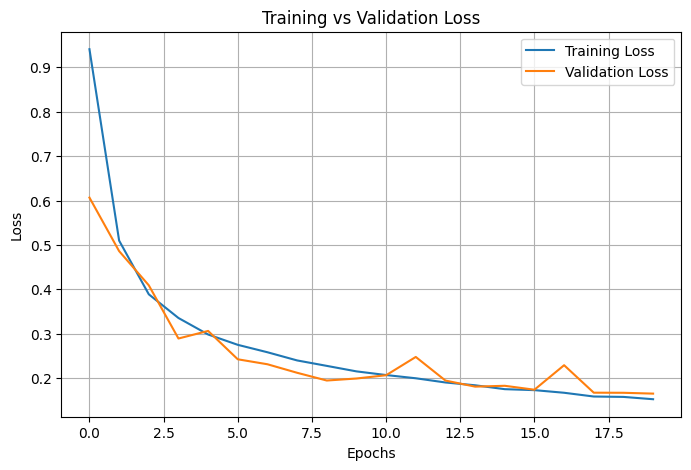

In [ ]:



# Load Pretrained Model with Dropout
class CustomResNet(nn.Module):
    def __init__(self):
        super(CustomResNet, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Sequential(
            nn.Dropout(0.4),  # Dropout added
            nn.Linear(self.model.fc.in_features, 3)
        )

    def forward(self, x):
        return self.model(x)

model = CustomResNet().to(device)


# Training with Early Stopping
train_losses, val_losses = [], []
best_val_loss = float('inf')
patience, counter = 5, 0  # Early stopping parameters

epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # Reduce LR if needed
    scheduler.step(avg_val_loss)

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save best model
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Plot Training vs Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()


Training vs Validation Grapgh to check overfitting

### **Why?**  
Loss alone doesn’t tell us how well the model classifies images.

 **Plot Train vs Validation Loss**  
- Ensures that **training and validation loss decrease together**.  
- Detects overfitting (if validation loss starts increasing while training loss keeps decreasing).  

 **ROC & AUC (Next Step)**  
- ROC-AUC **measures classification confidence** rather than just accuracy.  
- Helps understand **false positives vs true positives** balance.  


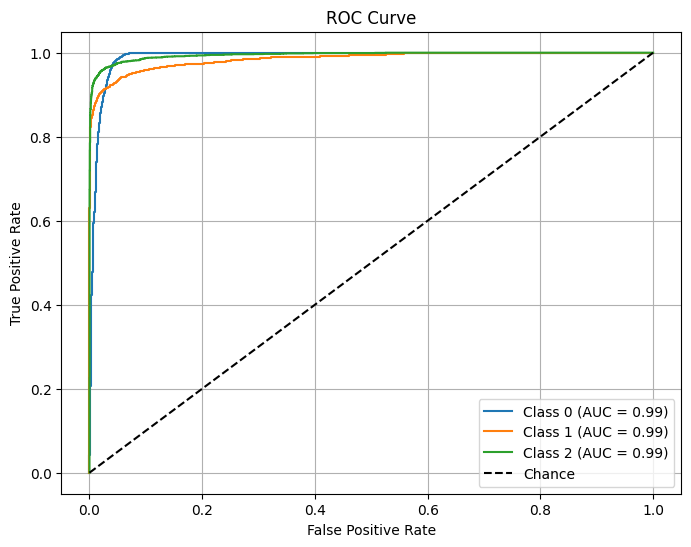

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Function to compute ROC and AUC
def compute_roc_auc(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)  # Convert logits to probabilities

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(probabilities.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

# Get labels and predictions
true_labels, pred_probs = compute_roc_auc(model, val_loader, device)

# Compute ROC curve and AUC for each class
plt.figure(figsize=(8, 6))
for i in range(3):  # 3 classes: 'no', 'sphere', 'vort'
    fpr, tpr, _ = roc_curve(true_labels == i, pred_probs[:, i])  # One-vs-all approach
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot the random chance line
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()
